# End-to-End Image Reconstruction methods

We are finally ready to describe more in details the main architecture used for end-to-end image reconstruction with neural networks. In particular, this chapter will focus not only on describing the main architectures commonly used in the literature, namely the Convolutional Neural Network (**CNN**), the **UNet** and the **Vision Transformer (ViT)**, but it will also delve into the detail on **why** some architectural choice is made and in which occasion one may want to slightly modify the default architecture. 

For the whole chapter we will consider as an example the inverse problem associated with the MotionBlur operator, considering the Mayo's Dataset already introduced in the previous chapter. At the end of this chapter, we will also investigate the Computed Tomography inverse problem, which requires more attention as, differently from the MotionBlur, in Computed Tomography (as well as in SuperResolution, and others), the dimensionality of the measurement $y^\delta$ is different from the dimensionality of the datum $x_{true}$.

## Convolutions and Padding

Working with images is a completely different task than working with tabular data, not only because the number of features in images is usually way higher than the number of features of tabular data, but also in the way these features should be considered. 

Indeed, when we analyze an image, the value of one given pixel **alone** is of low importance: we mostly care on the behavior of a set of neighbour pixels which, when taken together, produces a **visible object** in our image. But that's more, sometimes, we also care about more **global** information, i.e. how the object described by the neighbour of pixels interact with the other objects, with the environment, and its relative position inside the image.

More formally, if we define a **punctual information** as any information that can be extracted by considering a single pixel, isolated by its context, a **local information** as any information that can be extracted by a small set of neighbour pixels, and a **global information** as any information that requires a global knowledge on the value of each pixels in the image to be extracted, with a context that fullfils the whole image, then we can say than image processing task is mostly based on local and global information, with a very minority of punctual information. 

From this observation, one can note that the classical MLP architecture, defined by a chain of linear transformation alternated with non-linear activation functions, which processes each pixel as a single, isolated neuron, is meaningless. Indeed, it would be better to consider a network where each **linear** layer is substitued with a layer that takes into consideration **local** information. The simplest mathematical tool achieving this is the **Convolution** operation. 

```{image} /imgs/convolution.png
:width: 800px
:align: center
```

As shown in the image above, a convolution is a linear operation involving an input image $x$ with shape $n_x \times n_y$ and a convolution kernel $\mathcal{K}$, with shape $k \times k$, usually much smaller than the dimension of the image. Each pixel in position $(i, j)$ of the output image $y = \mathcal{K} \ast x$ is obtained by applying the center of the kernel to the pixel $(i, j)$ of the input image, then element-wise multiplying the convolution kernel with the corresponding pixels of the input image, and summing the result. In formula:

$$
y_{i, j} = \sum_{t= -\frac{k}{2}}^{\frac{k}{2}} \sum_{l = -\frac{k}{2}}^{\frac{k}{2}} \mathcal{K}_{t, l} x_{i - t, j - l}.
$$

As a result, each pixel of the output image $y$ is influenced by a $k \times k$ neighbourhood of the input image $x$, enforcing the required locality of the operation. 

```{note}
Sometimes the convolution kernel is considered to be applied on the upper-left corner instead of being center-applied. While this makes no difference in practice, it can slightly modify the formula.
```

One key limitation of Convolutions (clearly visible in the image above), is that the dimension of the output image is way lower than the dimension of the corresponding input. This makes convolutions impractical for end-to-end image reconstruction tasks, as we usually expect the output shape to be the same as the input shape.

To overcome this limitation, a technique which is usually considered is the **padding**, or **padded convolution**. The idea is to pad the input image with a given numbers of zeros to increase the dimensionality of the input image just before applying the convolution, so that the dimension of the output image is preserved after the application of the kernel. In practice, is the kernel shape is $k \times k$, one should pad the input with $\frac{k-1}{2}$ zeros at each side to preserve the image shape.
The result of a padded convolution is shown in the image below.

```{image} /imgs/padded-convolution.png
:width: 800px
:align: center
```

In the following, we will always consider padded convolution operation when working with images.

## Convolutional Neural Networks (CNN)

By exploiting the observation above, we can design a neural network architecture designed for working with images. Its simplest version, called **Convolutional Neural Network (CNN)**, is obtained by just considering a classical Multi-layer Perceptron (i.e. the simplest Neural Network architectures described in the previous chapter of this course) and substituting the `Linear` layer with a `Conv2d` layer. The **parameters** of a CNN architecture are the numbers contained in the convolution kernel, which describes how the processed pixels should be threated. 

In general, each convolution layer is composed by a large (pre-determined) set of convolution kernels with the same shape, each processing the same image in parallel and extracting different information from the image. Again, a common practice is to concatenate multiple convolutional layers one after the other, alternating them with non-linear activation functions like **ReLU**. 

```{note}
A common practice, justified by information theory, suggests that the number of convolutional kernels should increase as we go deeper in the network.
```

Let's see how to implement such a neural network architecture in Pytorch.

In [1]:
import torch
from torch import nn

class SimpleCNN(nn.Module):
    def __init__(self, in_ch, out_ch, n_filters, kernel_size=3):
        super().__init__()

        # Define (convolution) layers -> NOTE: padding="same" means "padded convolution"
        self.conv1 = nn.Conv2d(in_channels=in_ch, out_channels=n_filters, kernel_size=kernel_size, padding="same")
        self.conv2 = nn.Conv2d(in_channels=n_filters, out_channels=n_filters, kernel_size=kernel_size, padding="same")
        self.conv3 = nn.Conv2d(in_channels=n_filters, out_channels=out_ch, kernel_size=kernel_size, padding="same")

        self.relu = nn.ReLU()

    def forward(self, x):
        h = self.relu(self.conv1(x))
        h = self.relu(self.conv2(h))
        out = self.conv3(h)
        return out

The code above describes how to create a very simple Convolutional Neural Network with 3 convolution layers, each with a given number of filters and a kernel size of 3. Using a small kernel size (such as 3 or 5) is a common practice, as it makes the model more efficient taking the total number of parameters relatively small.

This model can be simply trained by using the exact same cycle as in the previous chapter with the sole difference that, since it is not a model from IPPy, its weights need to be save via the following command:

```
torch.save(model.state_dict(), PATH-TO-SAVE.pth)
```

and loaded via:

```
model.load_state_dict(torch.load(PATH-TO-SAVE.pth, weights_only=True))
```

/Users/davideevangelista/computational-imaging/end-to-end/../IPPy/operators.py:16: UserWarning: CuPy not found. GPU acceleration for ASTRA via CuPy will be disabled.
  warnings.warn(


Shape of x_true: torch.Size([1, 1, 256, 256]). Range of x_true: (tensor(0.), tensor(1.))
SSIM: 0.9405


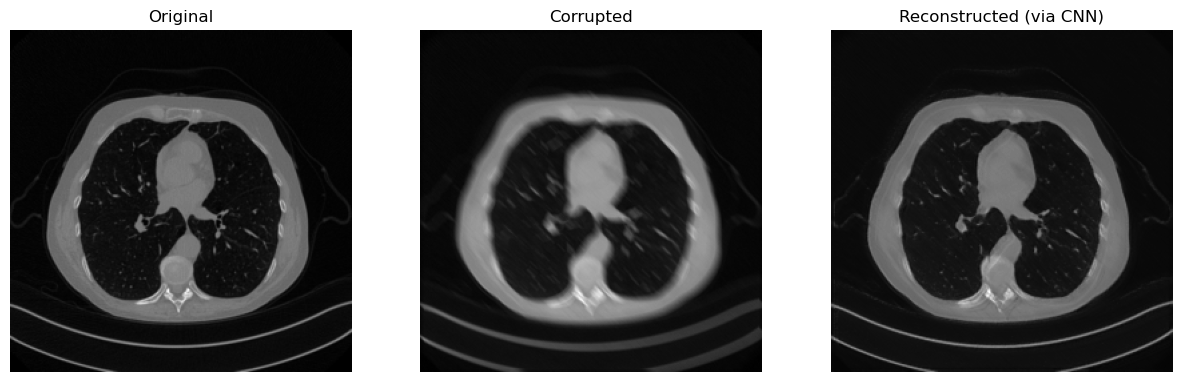

In [2]:
#-----------------
# This is just for rendering on the website
import os
import sys
import glob
sys.path.append("..")
#-----------------

from IPPy import operators, utilities, metrics

from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Set device
device = utilities.get_device()

# Define model
model = SimpleCNN(in_ch=1, out_ch=1, n_filters=64, kernel_size=3).to(device)

# Load model weights and send to CUDA
model.load_state_dict(torch.load("../weights/CNN.pth", weights_only=True, map_location=torch.device('cpu')))
model = model.to(device)

# Generate test image
class MayoDataset(Dataset):
    def __init__(self, data_path, data_shape):
        super().__init__()

        self.data_path = data_path
        self.data_shape = data_shape

        # We expect data_path to be like "./data/Mayo/train" or "./data/Mayo/test"
        self.fname_list = glob.glob(f"{data_path}/*/*.png")

    def __len__(self):
        return len(self.fname_list)
    
    def __getitem__(self, idx):
        # Load the idx's image from fname_list
        img_path = self.fname_list[idx]

         # To load the image as grey-scale
        x = Image.open(img_path).convert("L")

        # Convert to numpy array -> (512, 512)
        x = np.array(x) 

        # Convert to pytorch tensor -> (1, 512, 512) <-> (c, n_x, n_y)
        x = torch.tensor(x).unsqueeze(0)

        # Resize to the required shape
        x = transforms.Resize(self.data_shape)(x) # (1, n_x, n_y)

        # Normalize in [0, 1] range
        x = (x - x.min()) / (x.max() - x.min())

        return x

# Load test data   
test_data = MayoDataset(data_path="../data/Mayo/test", data_shape=256)
x_true = test_data[0].unsqueeze(0)

# Check whether it is a standardized tensor
print(f"Shape of x_true: {x_true.shape}. Range of x_true: {x_true.min(), x_true.max()}")

# Define MotionBlur operator (with a 45° angle)
K = operators.Blurring(img_shape=(256, 256), 
                       kernel_type="motion", 
                       kernel_size=7, 
                       motion_angle=45,)

# Compute blurred version of x_true
y = K(x_true)

# Add noise
y_delta = y + utilities.gaussian_noise(y, noise_level=0.01)

# Apply model to reconstruct image
x_rec = model(y_delta.to(device))

# Print SSIM
print(f"SSIM: {metrics.SSIM(x_rec.cpu(), x_true.cpu()):0.4f}")

# Visualize
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(x_true.detach().cpu().squeeze(), cmap='gray')
plt.axis('off')
plt.title('Original')

plt.subplot(1, 3, 2)
plt.imshow(y_delta.detach().cpu().squeeze(), cmap='gray')
plt.axis('off')
plt.title('Corrupted')

plt.subplot(1, 3, 3)
plt.imshow(x_rec.detach().cpu().squeeze(), cmap='gray')
plt.axis('off')
plt.title('Reconstructed (via CNN)')
plt.show()

Given a trained CNN, we can also investigate what are e.g. the operation learnt on the first convolutional layer:

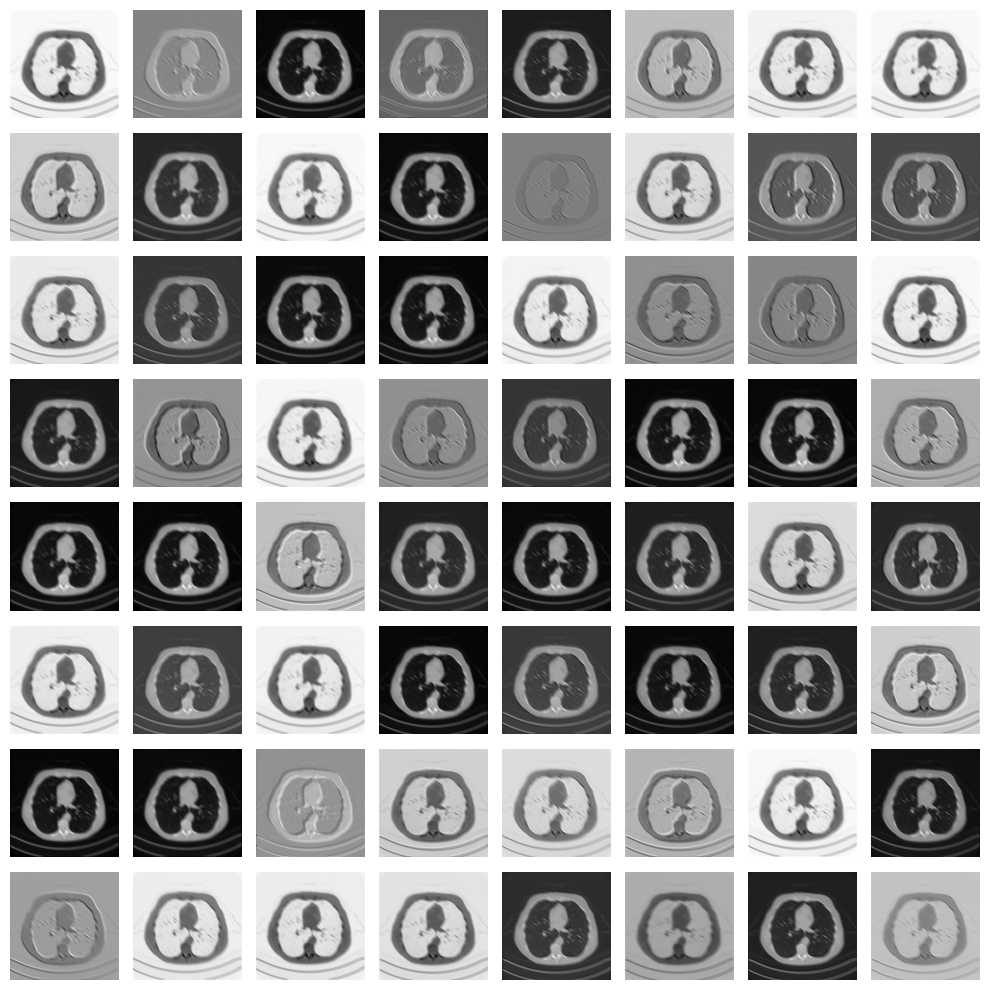

In [3]:
# Variable to store the output
activation = {}

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# Register the hook
model.conv1.register_forward_hook(get_activation('conv1'))

# Process image
x_rec = model(y_delta.to(device))

# Get the conv1 activation
conv1_output = activation['conv1']  # Shape: [1, 64, 256, 256]

# Plot all channels
fig, axes = plt.subplots(8, 8, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(conv1_output[0, i].cpu(), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

As you can see, each convolutional layer visualizes a particular pattern of the input image, each of which is then processed again by the second convolutional layer to attempt to solve the image reconstruction task.

Note that the visual quality of the resulting image is not that good compared e.g. with the UNet prediction from the previous chapter. Indeed, this happens mostly because the model is too small and has too few parameters. To get the number of parameters of the model in Pytorch, we can do as follows:

In [4]:
# Get number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {num_params}")

Total trainable parameters: 38145


### Translation Equivariance

So, CNN are a great alternative to MLP as they process data based on local information instead of punctual information, which better fits with the intuition on how images should be threated. However, is that the whole story? Are there other properties of Convolutional Neural Networks that make them favorable for end-to-end image reconstruction task? The answer is, clearly, yes.

Arguably the most important of those properties is the **translation equivariance**. Formally, a function $f_\Theta$ is said to be translation equivariant if for any vector $v$, it holds:

$$
f_\Theta(x + v) = f_\Theta(x) + v.
$$

Intuitively, it means that the output of the model is **independent** on the position of an object in the image, e.g. a bird on the upper-left of the image is threated in the exact same way as if the same bird is on the lower-right side. This property, which inheritates from the properties of convolutions and by that activation functions are applied element-wise, follows the most classical intuition on how vision works, confirming that convolutions are a great tool to work with image reconstruction tasks, and explaining the success of these kind of models. 

### Final activation function

While we already observed that the default choice for basically every activation function is ReLU or a variant of ReLU, particular attention should be used when choosing the activation function for the last layer. 

Up to this moment, we always considered neural network models with **no final activation**, i.e. the last operation performed by the model is a linear operation (or a convolution), leading to a model which is able to generate output data with every possible value, from $- \infty$ to $+ \infty$. However, we could also consider other activation functions which are more suitable for image processing tasks, each coming with their own pros and cons:

* **ReLU:** Applying a ReLU activation function as the final activation for our model looks promising: since we already know that each standardized image should lie in the $[0, 1]$ range, enforcing each pixel to be at least positive seems great. Indeed, when ReLU is employed as final activation, the reconstructed image looks better, particularly in the background, where it becomes easier for the model to generate a perfectly black background. However, ReLU comes with the downside of non-differentiability on $0$ which, being $0$ exactly the value we want to reach for the background, can cause training instabilities.
* **Sigmoid:** From the perspective of the range, using sigmoid as final activation seems even more promising, as its range is $(0, 1)$, which is almost equivalent to the range of any standardized tensor. While this choice led to a reconstruction which is proven to lie in the correct domain, training with this choice of final activation function is usually pretty unstable. This is due to the fact that sigmoid **approaches** $0$ and $1$ at $-\infty$ and $+ \infty$, respectively. Therefore, trying to match the value of $0$ in the background, the optimizer tries to push the weights to infinity, causing the instability.
* **Tanh:** Tanh is the commonly-used activation function when working with Residual CNN (which we will introduce later) as, being its range $(-1, 1)$, they are well-suited in learning an approximation of the residucal mapping. When used on non-Residual CNN, this final activation suffers the same instability issues of sigmoid.

To conclude this section, the general reccomendation is to always use either ReLU or no activation for general CNN, while using Tanh for Residual CNN. Whether to use ReLU or no activation depends on the specific activation and needs to be tested case-by-case. 

### Residual CNN

Any CNN for image processing works by identifying **patterns** in the input image, which has been previously learnt (during training), and by reconstructing each pattern separately the same way it has been learnt during the training. For this reason, if e.g. we train a model to Deblur images of cat, there is no way the same model will be able to Deblur images of dogs: the different patterns in images of dogs makes impossible for the model to reconstruct them accurately. 

Consequently, a large field of reseach in CNN for image processing tries to teach models to identify the patterns that are typical for the **task** you want to solve, rather than patterns in the training data. To this aim, we can observe that while the pattern in the image are usually dataset-specific, the **artifact** (i.e. the difference between the corrupted image and the true image) tends to exhibit task-related patterns.

To make an example, consider the following problem where two images coming from two completely different datasets gets corrupted by Gaussian Blur and some noise. By looking at both the true and the corrupted image, it is clear how the **content** of the two images is very different.
On the other side, when we take a look at the **residual**, i.e. the value $|x_{true} - y^\delta|$, the patterns in the two images looks similar. 

This observation justifies that **learning the residual is usually easier (and generalizes better) than learning the actual image**.

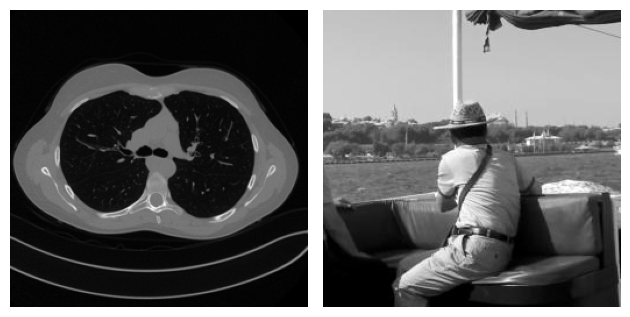

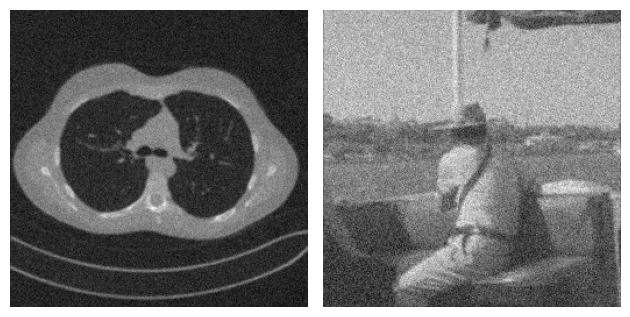

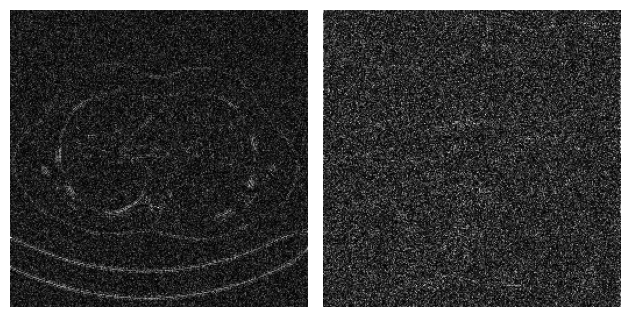

In [5]:
from PIL import Image
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPPy import operators
from torchvision import transforms

# Load images
x_mayo = torch.tensor(np.array(Image.open("../imgs/Mayo.png").convert("L"))).unsqueeze(0).unsqueeze(1)
x_mayo = transforms.Resize(size=256)(x_mayo)
x_mayo = (x_mayo - x_mayo.min()) / (x_mayo.max() - x_mayo.min())

x_gopro = torch.tensor(np.array(Image.open("../imgs/GoPro.jpg").convert("L"))).unsqueeze(0).unsqueeze(1)
x_gopro = transforms.Resize(size=256)(x_gopro)
x_gopro = (x_gopro - x_gopro.min()) / (x_gopro.max() - x_gopro.min())

# Visualize the images
plt.subplot(1, 2, 1)
plt.imshow(x_mayo.squeeze(), cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(x_gopro.squeeze(), cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

# Corrupt and add noise
K = operators.Blurring(img_shape=(256, 256), kernel_type="gaussian", kernel_size=3, kernel_variance=1)

y_mayo = K(x_mayo)
y_mayo_delta = y_mayo + utilities.gaussian_noise(y_mayo, noise_level=0.2)

y_gopro = K(x_gopro)
y_gopro_delta = y_gopro + utilities.gaussian_noise(y_gopro, noise_level=0.2)

# Visualize the (corrupted) images
plt.subplot(1, 2, 1)
plt.imshow(y_mayo_delta.squeeze(), cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(y_gopro_delta.squeeze(), cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

# Visualize the residual
plt.subplot(1, 2, 1)
plt.imshow(torch.abs(y_mayo_delta - x_mayo).squeeze(), cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(torch.abs(y_gopro_delta - x_gopro).squeeze(), cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

With this idea in mind, some authors developed a variant of the simple CNN architecture discussed before, where the network is trained to learn **not** the reconstructed image, but rather the **residual**, which is then converted to the actual image by just adding the corrupted image $y^\delta$ back to the output of the model. The operation of summing the input back to the output with the aim of learning the residual is usually called **residual connection** or **skip connection**. This architectures are named **Residual Convolutional Neural Netowork (ResCNN)**. 

What follows is a Pytorch implementation of a ResCNN architecture with the same basic structure as the CNN we discussed previously. Note that we employ Tanh as final activation function for this task, as we already discussed in the previous section.

In [6]:
import torch
from torch import nn

class ResCNN(nn.Module):
    def __init__(self, in_ch, out_ch, n_filters, kernel_size=3):
        super().__init__()

        # Define (convolution) layers -> NOTE: padding="same" means "padded convolution"
        self.conv1 = nn.Conv2d(in_channels=in_ch, out_channels=n_filters, kernel_size=kernel_size, padding="same")
        self.conv2 = nn.Conv2d(in_channels=n_filters, out_channels=n_filters, kernel_size=kernel_size, padding="same")
        self.conv3 = nn.Conv2d(in_channels=n_filters, out_channels=out_ch, kernel_size=kernel_size, padding="same")

        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        h = self.relu(self.conv1(x))
        h = self.relu(self.conv2(h))
        out = self.tanh(self.conv3(h))
        return out + x

Training this model on the same setup as the previous one, led to the following results:

Shape of x_true: torch.Size([1, 1, 256, 256]). Range of x_true: (tensor(0.), tensor(1.))
SSIM: 0.9408


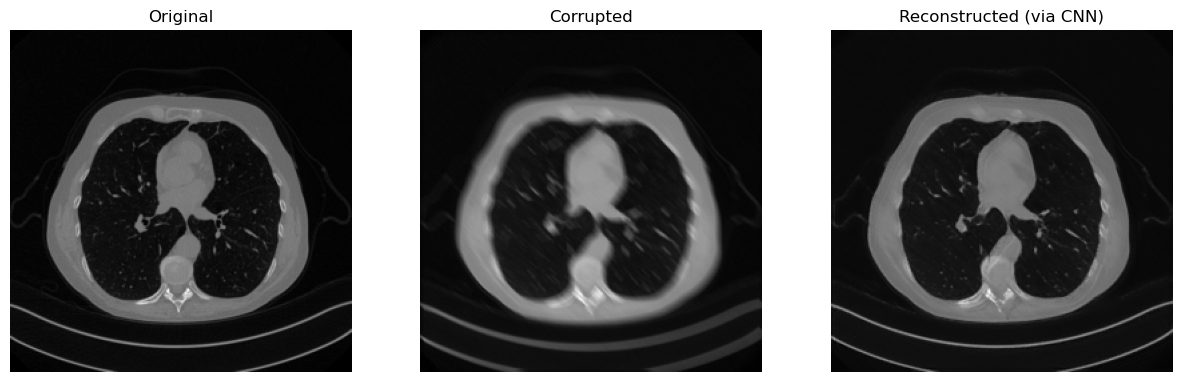

In [7]:
#-----------------
# This is just for rendering on the website
import os
import sys
import glob
sys.path.append("..")
#-----------------

from IPPy import operators, utilities, metrics

from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Set device
device = utilities.get_device()

# Define model
model = ResCNN(in_ch=1, out_ch=1, n_filters=64, kernel_size=3).to(device)

# Load model weights and send to CUDA
model.load_state_dict(torch.load("../weights/ResCNN.pth", weights_only=True, map_location=torch.device('cpu')))
model = model.to(device)

# Generate test image
class MayoDataset(Dataset):
    def __init__(self, data_path, data_shape):
        super().__init__()

        self.data_path = data_path
        self.data_shape = data_shape

        # We expect data_path to be like "./data/Mayo/train" or "./data/Mayo/test"
        self.fname_list = glob.glob(f"{data_path}/*/*.png")

    def __len__(self):
        return len(self.fname_list)
    
    def __getitem__(self, idx):
        # Load the idx's image from fname_list
        img_path = self.fname_list[idx]

         # To load the image as grey-scale
        x = Image.open(img_path).convert("L")

        # Convert to numpy array -> (512, 512)
        x = np.array(x) 

        # Convert to pytorch tensor -> (1, 512, 512) <-> (c, n_x, n_y)
        x = torch.tensor(x).unsqueeze(0)

        # Resize to the required shape
        x = transforms.Resize(self.data_shape)(x) # (1, n_x, n_y)

        # Normalize in [0, 1] range
        x = (x - x.min()) / (x.max() - x.min())

        return x

# Load test data   
test_data = MayoDataset(data_path="../data/Mayo/test", data_shape=256)
x_true = test_data[0].unsqueeze(0)

# Check whether it is a standardized tensor
print(f"Shape of x_true: {x_true.shape}. Range of x_true: {x_true.min(), x_true.max()}")

# Define MotionBlur operator (with a 45° angle)
K = operators.Blurring(img_shape=(256, 256), 
                       kernel_type="motion", 
                       kernel_size=7, 
                       motion_angle=45,)

# Compute blurred version of x_true
y = K(x_true)

# Add noise
y_delta = y + utilities.gaussian_noise(y, noise_level=0.01)

# Apply model to reconstruct image
x_rec = model(y_delta.to(device))

# Print SSIM
print(f"SSIM: {metrics.SSIM(x_rec.cpu(), x_true.cpu()):0.4f}")

# Visualize
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(x_true.detach().cpu().squeeze(), cmap='gray')
plt.axis('off')
plt.title('Original')

plt.subplot(1, 3, 2)
plt.imshow(y_delta.detach().cpu().squeeze(), cmap='gray')
plt.axis('off')
plt.title('Corrupted')

plt.subplot(1, 3, 3)
plt.imshow(x_rec.detach().cpu().squeeze(), cmap='gray')
plt.axis('off')
plt.title('Reconstructed (via CNN)')
plt.show()

### Beyond CNN: the Receptive field

Modern neural network architectures for image processing tasks rarely uses the simple CNN model described above. One of the reasons for that is a concept named **Receptive Field (RF)**. To understand the concept of RF, let's take as example a model with $L$ convolutional layers, each having a kernel size of $\kappa_l = 3$, as depicted in the following Figure. It's evident that each pixel in the feature map of the second layer is influenced only by a $3 \times 3$ portion of the first layer (the input of the network). Similarly, each pixel in the feature map of the third layer is influenced by a $3 \times 3$ portion of the previous layer, and consequently by a $5 \times 5$ portion of the input image. The number of input image pixels that affect the value of each pixel in the $l$-th feature map is what we call the receptive field of the $l$-th layer. By continuing this process through the network's layers to the output, we can compute the receptive field of the network, which represents the number of input image pixels that influence the network's output. This measurement is crucial because when reconstructing corrupted data containing artifacts, understanding the RF helps ensure that the model captures and addresses these artifacts accurately. In particular, when the artifacts are local, a small receptive field is enough to give the model the ability to distinguish between the artifact and the image features for the reconstruction, while when the artifacts are global a large RF is required to produce an accurate reconstruction.

```{image} /imgs/receptive_field.png
:width: 800px
:align: center
```

Since we are interested in comparing neural network architectures in terms of their receptive field, we need to derive a formula to compute it for any given network. For each layer $l$, let $\kappa_l$ and $s_l$ be its kernel dimension and stride, respectively. Moreover, let $r_l$ be the receptive field, where the receptive field of the input layer is $r_0 = 1$ by definition. The value of $r_l$ can be computed with the recursive formula:

$$
    r_l = r_{l-1} + A_l,
$$

where $A_l$ is the non-overlapping area between subsequent filter applications. Note that $A_l$ can be simply computed as

$$
    A_l = (k_l - 1) \prod_{i=1}^l s_i,
$$

which implies that the receptive field at each $l$-th layer is:

$$
\begin{aligned}
    &r_0 = 1 \\
    &r_l = r_{l-1} + (k_l - 1) \prod_{i=1}^l s_i.
\end{aligned}
$$

This equation shows that the receptive field scales linearly with the depth of the network if the kernel dimension is fixed, while it is exponentially related to the stride. For this reason, utilizing strided convolutional layers exponentially enlarges the receptive field of the model.

## UNet

Combining all the information discussed above, we are now ready to introduce arguably the most important neural network model for image reconstruction ever developed: **UNet**. The UNet is a multi-scale variant of the Convolutional Neural Network architecture, which is able to easily detect and correct both global and local artifacts. The UNet architecture, as depicted in the Figure below, is a **fully convolutional neural network** with a **symmetric encoder-decoder structure** and **strided convolutions** to enlarge its receptive field. The strides in the encoder layers naturally divide the network into distinct levels of resolution, to which we will refer as $g$, $g = 0, \dots, \mathcal{G}$, where $\mathcal{G}+1$ is the total number of levels in the network. At each level, a fixed number $n_g$ of blocks $B_1, \dots B_{n_g}$ is applied. Specifically, each block is defined as a convolutional layer with number $c_g$ of channels constant along the level, followed by a batch normalization layer and then by a ReLU activation function. Given a baseline number of convolutional channels $c_0$ (that corresponds to the number of channels in the first level), we compute $c_g$ for the next levels with the recursive formula $c_{g+1} = 2c_{g}$, $g=0, \dots, L-1$. In particular, we fixed $\mathcal{G}=4$, $n_0 = \dots = n_3 = 3$ and $c_0 = 64$ in the experiments. 
As already said, the decoder is symmetric to the encoder, with upsampling convolutional layers instead of strided convolutions. Moreover, to maintain high-frequency information, skip connections are added between the last layer at each level of the encoder and the first layer at the correspondent level of the decoder. To reduce the number of parameters with respect to the original architecture, it is common to implement the skip connections as additions instead of concatenations. A residual connection is added between the input layer and the output layer too as discussed previously. The output of the resulting model can be mathematically described as:

$$
    F_\Theta(y^\delta) = y^\delta + f_\Theta(y^\delta),
$$

which implies that the network has to learn the residual mapping between the input and the expected output. For this reason, this model has been named **Residual UNet (ResUNet)** in the literature. The importance of the residual connection has been observed in a theoretical work by Han et al., where the authors proved that the residual manifold containing the artifacts is easier to learn than the true image manifold. Like any Residual Neural Network model, we usually employ a Tanh activation function in the last layer.

```{image} /imgs/ResUNet.png
:width: 800px
:align: center
```

The UNet architecture can be easily implemented via IPPy, as already done in the previous chapter. Note that, due to its structure, the UNet model is relatively efficient even when the number of parameters grows to milions or even tenths of milions.

### ResidualConvBlock

As you maybe already observed, the Convolutional Block at each resolution level of the UNet architecture in IPPy are called `ResidualConvBlock`. This is because, to make the training even more effective, skip connections are added to every single convolutional layer (i.e. the input is summed back to the output of every convolutional block). In general, this is the most classical choice for designing effective UNet architectures for end-to-end image processing tasks.

### AttentionConvBlock

An alternative for the ResidualConvBlock in `IPPy`-based UNet architectures are the `AttentionDownBlock` and `AttentionUpBlock`. While discussing how attention work in details is beyond the scope of this course, it is sufficient to know that when `Attention` layers are employed, they usually substitute the classical skip-connection, creating a **gated** version of the skip-connection which is trained to teach the model to focus on a particular portion of the image, at each convolutional filter. 
Usually, `Attention` layers are used in UNet at the second last resolution level, as it has shown to perform better in practice.

## Guiding the Model via Loss Function Selection

Up to this point, our default selection for the loss function has been the `MSELoss` (Mean Squared Error). While it generally performs reasonably well, it can be suboptimal in specific scenarios, particularly when focusing on fine details within an image is crucial. As we've previously noted, meaningful information content in images is often **local** in nature. Consequently, pixel-wise metrics like MSE fail to adequately capture pattern information or structural details that the human visual system readily identifies as indicative of **good** image quality.

A practical example highlights this issuem indicated in the figure below: often, multiple images that appear significantly different to the human eye can exhibit the exact same MSE distance from a ground-truth image. Therefore, selecting the best candidate *solution* among these cannot be based solely on the MSE metric.

```{image} /imgs/MSEIssue.png
:width: 800px
:align: center
```


To address this limitation, a significant line of research in applying neural networks to image reconstruction tasks focuses on developing better loss functions (or combinations thereof) to achieve visually superior reconstruction quality. Below, we list and briefly discuss some common and effective loss functions:

* **$\ell_{L1}$ (L1 Loss / MAE)**: The $\ell_{L1}$ loss, also known as Mean Absolute Error (MAE), represents the $\ell_1$-norm equivalent of the MSELoss (which uses the $\ell_2$-norm). It is readily available in PyTorch via `torch.nn.L1Loss()` and is defined as:

    $$
    \ell_{L1}(y_{true}, y_{pred}) = \frac{1}{N} \sum_{i=1}^N || y^{(i)}_{true} - y^{(i)}_{pred} ||_1,
    $$

    where $|| y^{(i)}_{true} - y^{(i)}_{pred} ||_1$ denotes the sum over all pixels of the absolute value of the difference between the true image $y^{(i)}_{true}$ and the corresponding prediction $y^{(i)}_{pred}$. While the $\ell_{L1}$ loss is often associated with producing sharper images compared to MSELoss, it has the theoretical drawback of not being differentiable at zero. In practice, subgradient methods are effective, but this can sometimes lead to less stable training compared to MSE. Furthermore, it still suffers from limitations similar to MSELoss, as it remains a pixel-wise metric, potentially failing to capture structural context.

* **$\ell_{Fourier}$ (Fourier Loss)**: The $\ell_{Fourier}$ loss exploits the observation that high frequencies in an image (representing fine details and textures) are often harder for convolution-based neural networks to reconstruct accurately than low frequencies (representing overall intensity and large structures). Moreover, accurately recovering these fine details often makes the reconstructed image appear sharper and more realistic to the human eye. It is typically defined based on the difference in the Fourier domain:

    $$
    \ell_{Fourier}(y_{true}, y_{pred}) = \frac{1}{N} \sum_{i=1}^N || HP(\mathcal{F}y^{(i)}_{true} - \mathcal{F}y^{(i)}_{pred}) ||_p^p,
    $$

    Here, $\mathcal{F}$ denotes the 2D Fourier transform operator, $HP(\cdot)$ represents a high-pass filter (which attenuates or removes low frequencies while preserving high frequencies), and $|| \cdot ||_p^p$ usually indicates the squared $\ell_2$-norm ($p=2$) or the $\ell_1$-norm ($p=1$).
    Note that while this loss operates pixel-wise in the *Fourier domain*, each Fourier coefficient relates to global spatial frequency content (like patterns or textures) in the image domain. Therefore, it can be considered less strictly local than pixel-wise losses in the image spatial domain and potentially closer to how humans perceive certain aspects of image quality compared to MSELoss or the $\ell_{L1}$ loss. However, a significant drawback is that focusing primarily on high frequencies neglects low-frequency information. Thus, the $\ell_{Fourier}$ loss is typically used *in combination* with other losses (like MSE or $\ell_{L1}$) to ensure the overall structure and context of the image are also reconstructed accurately, leading to a satisfactory result.

* **$\ell_{SSIM}$ (SSIM Loss)**: An alternative approach focusing on perceptual similarity is the $\ell_{SSIM}$ loss. It is based on the Structural Similarity Index Measure (SSIM), a widely used metric designed to quantify the *visual similarity* between two images. SSIM is known for correlating well with human perception of image quality because it compares local patches based on luminance, contrast, and structure. SSIM typically outputs a value where 1 indicates higher similarity. Since neural network training aims to **minimize** the loss, the $\ell_{SSIM}$ loss is commonly defined by subtracting the SSIM value from 1:

    $$
    \ell_{SSIM}(y_{true}, y_{pred}) = \frac{1}{N} \sum_{i=1}^N \left( 1 - SSIM(y^{(i)}_{true}, y^{(i)}_{pred}) \right).
    $$

    The $\ell_{SSIM}$ loss is popular in image processing tasks because optimizing it often leads to visually pleasing results. This success is partly attributed to SSIM's mechanism, which analyzes images in terms of local structure, making it inherently more sensitive to context than purely pixel-wise metrics.

* **$\ell_{Perceptual}$ (Perceptual Loss)**: Building upon the idea of using metrics relevant to human perception, Perceptual Losses ($\ell_{Perceptual}$) offer another powerful alternative. Instead of comparing pixels directly or using hand-crafted metrics like SSIM, this approach leverages features extracted by a deep neural network (typically a network pre-trained on a large dataset like ImageNet, e.g., VGG or ResNet). The core idea is that the intermediate layers of these networks learn hierarchical representations of visual features (edges, textures, parts of objects, etc.) that are relevant to perception. The $\ell_{Perceptual}$ loss is calculated by comparing these feature representations for the predicted and ground-truth images:

    $$
    \ell_{Perceptual}(y_{true}, y_{pred}) = \frac{1}{N} \sum_{i=1}^N \sum_{l} \lambda_l || \phi_l(y^{(i)}_{true}) - \phi_l(y^{(i)}_{pred}) ||_p^p,
    $$

    where $\phi_l(y)$ represents the feature map activation of image $y$ extracted from a specific layer $l$ of the pre-trained network, $|| \cdot ||_p^p$ is typically the $\ell_1$ ($p=1$) or $\ell_2$ ($p=2$) distance computed across the feature map dimensions, and $\lambda_l$ are weighting factors for combining losses from multiple layers ($l$). During training, the pre-trained network used for feature extraction ($\phi$) is kept frozen (its weights are not updated).
    The $\ell_{Perceptual}$ loss often yields reconstructions that are considered highly realistic and visually detailed, excelling at capturing complex textures and structures. However, it is computationally more expensive than other losses as it requires an additional forward pass through the feature extractor network. It also introduces a dependency on the specific pre-trained model and the chosen layers, which might require tuning for optimal performance on a given task. Furthermore, a key limitation is its reliance on these large pre-trained networks. This dependency can make $\ell_{Perceptual}$ impractical or unsuitable for applications where such large models are not readily available, cannot be easily deployed due to computational or memory constraints, or where the features learned on general datasets like ImageNet may not be optimal. This is particularly relevant in specialized domains like medical imaging (e.g., Computed Tomography - CT), where domain-specific features are crucial and the use of large, general-purpose models might be inappropriate or less effective.

Given that each of the aforementioned loss functions ($\ell_{L1}$, $\ell_{Fourier}$, $\ell_{SSIM}$, $\ell_{Perceptual}$, as well as MSE) possesses distinct advantages and disadvantages, a common and often highly effective strategy in practice is to utilize a **Combination Loss**. This approach involves combining multiple loss functions into a single objective function, typically as a weighted sum. For instance, a combination loss $\ell_{Combined}$ could be formulated as:

$$
\ell_{Combined} = \lambda_1 \ell_{Loss1} + \lambda_2 \ell_{Loss2} + \dots + \lambda_K \ell_{LossK}
$$

where $\ell_{LossK}$ represents one of the individual loss functions discussed (e.g., MSE, $\ell_{L1}$, $\ell_{SSIM}$, $\ell_{Perceptual}$), and $\lambda_k \ge 0$ are hyperparameters representing the weight assigned to each component loss. By carefully tuning these weights $\lambda_k$, researchers and practitioners can aim to strike an optimal balance, leveraging the strengths of different losses (e.g., pixel accuracy from MSE, sharpness from $\ell_{L1}$, structural fidelity from $\ell_{SSIM}$, perceptual realism from $\ell_{Perceptual}$) while potentially mitigating their individual weaknesses. This allows for greater flexibility in tailoring the optimization process towards achieving the desired reconstruction quality, finding a suitable compromise between the various trade-offs.